# Proyecto final - Parte 2

Bazúa Lobato María del Mar y
Medina Islas Néstor Enrique

## Objetivo

Derivado de los resultados obtenidos utilizando con el modelo de SAM, decidimos probar con otro modelo que nos diera resultados más precisos. Explorando encontramos el modelo de YOLO desarrollado por Ultralytics (https://github.com/ultralytics/ultralytics?tab=readme-ov-file).

## Aquitectura del modelo YOLO

YOLO (You Only Look Once) es una arquitectura de detección de objetos en imágenes que se caracteriza por su velocidad y eficiencia. A diferencia de otros métodos que escanean la imagen por regiones, YOLO realiza la detección en una sola pasada (one forward pass) de la red neuronal, permitiendo detectar múltiples objetos en tiempo real.

YOLO utiliza una arquitectura de red neuronal convolucional (CNN) como base, adaptada para realizar simultáneamente las tareas de localización (regresión de bounding boxes) y clasificación (detección de clases).

A continuación mostraremos como utilizar este modelo desde la descarga como la adaptación que realizamos para la detección de objetos deseados. Una gran ventaja de este modelo es que permite identificar clases en específico y no objetos en general. Para nuestro propósito, buscaremos identificar 7 cuantificar las clases de "bottle" (botella) y "can" (lata).



In [1]:
# Primero, verifica que estás en Colab
import os
from google.colab import drive

# Montar Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


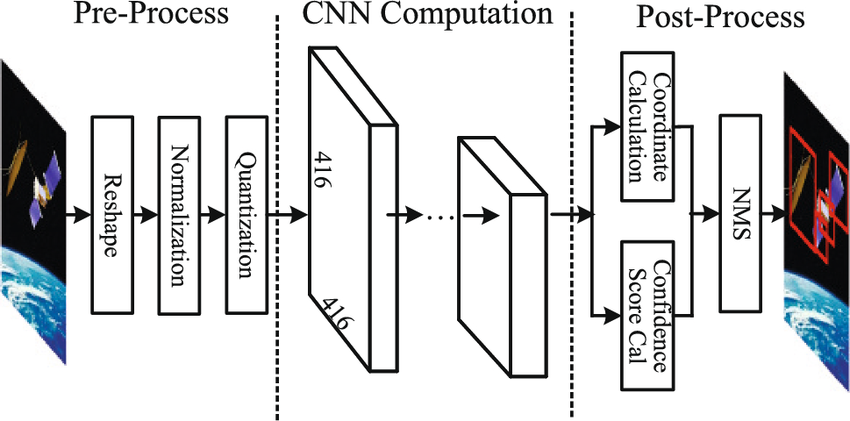

In [2]:
from IPython.display import Image, display

img_path = '/content/drive/My Drive/Colab Notebooks/Architecture-of-the-YOLO-network.png'  # adjust this path
display(Image(filename=img_path))

Instalar YOLO y las librerías necesarias

Es necesario descargar el archivo y resguardarlo en una carpeta. El modelo se encuentra disponible en la siguiente ruta: <br> https://docs.ultralytics.com/es/tasks/detect/

In [3]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00


Conectar cuaderno con Drive para acceder a archivos

Librerías necesarias

In [4]:
from ultralytics import YOLO
import cv2
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image, ExifTags
import numpy as np
import tempfile

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Las siguientes son las funciones para utilizar el modelo, tanto ajustes necesarios en las imágenes (pre-procesamiento), la predicción de las clases en la imagen deseada, el conteo de clases y la opción de graficar las imágenes con las etiquetas.

In [5]:
def correct_image_orientation(image):
    try:
        # Buscar la etiqueta de orientación en los metadatos EXIF
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = image._getexif()
        if exif is not None:
            orientation = exif[orientation]
            # Ajustar orientación dependiendo del valor EXIF
            if orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        # Algunas imágenes no tienen EXIF, así que ignoramos errores
        pass
    return image

def get_yolo(path, save_path, visualizar=False,sizeA = 8, sizeB = 4):
    # Cargar modelo YOLO entrenado previamente
    model = YOLO("/content/drive/My Drive/Colab Notebooks/Yolo8/yolo11n.pt")

    # Especificar qué clases nos interesan
    desired_classes = ['can', 'bottle']

    # Abrir la imagen con PIL para aplicar corrección de orientación
    pil_image = Image.open(path)
    pil_image = correct_image_orientation(pil_image)

    # Redimensionar la imagen para hacerla más ligera (opcional)
    pil_image_resized = pil_image.resize((pil_image.width // 2, pil_image.height // 2))
    original_img_array = np.array(pil_image_resized)

    # Leer imagen en formato OpenCV (BGR) para procesar con YOLO
    image = cv2.imread(path)

    # Realizar predicción con el modelo (umbral de confianza bajo para no perder detecciones)
    results = model.predict(source=image, conf=0.05)

    # Contador por clase
    counts = {cls: 0 for cls in desired_classes}

    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Coordenadas del bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])  # Confianza
            cls = int(box.cls[0])      # Índice de clase
            class_name = model.names[cls]

            # Filtrar solo clases de interés
            if class_name in desired_classes:
                label = f'{class_name} {conf:.2f}'
                # Dibujar caja verde
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Parámetros para el texto
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.6
                thickness = 2
                text_color = (255, 255, 255)  # Blanco
                bg_color = (0, 0, 0)          # Negro

                # Calcular tamaño del texto para poner fondo
                text_size, _ = cv2.getTextSize(label, font, font_scale, thickness)
                text_w, text_h = text_size
                text_x, text_y = x1, y1 - 10 if y1 - 10 > 10 else y1 + text_h + 10

                # Dibujar rectángulo de fondo para el texto
                box_coords = ((text_x, text_y - text_h - 4), (text_x + text_w + 4, text_y))
                cv2.rectangle(image, box_coords[0], box_coords[1], bg_color, cv2.FILLED)

                # Escribir texto sobre el fondo negro
                cv2.putText(image, label, (text_x + 2, text_y - 4), font, font_scale, text_color, thickness)

                # Sumar al contador
                counts[class_name] += 1

    # Guardar imagen resultante con detecciones
    cv2.imwrite(save_path, image)

    # Si se activa la opción visualizar, se muestran las imágenes comparadas
    if visualizar:
        # Convertir imagen con YOLO a RGB para mostrar con matplotlib
        yolo_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Mostrar lado a lado: original vs con detecciones
        fig, axs = plt.subplots(1, 2, figsize=(sizeA, sizeB))
        axs[0].imshow(original_img_array)
        axs[0].set_title("Imagen Original")
        axs[0].axis('off')

        axs[1].imshow(yolo_rgb)
        axs[1].set_title("YOLO Detectado")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

    # Retornar total de objetos detectados (sumando todas las clases)
    return sum(counts.values())


0: 640x480 23 bottles, 1 refrigerator, 93.5ms
Speed: 18.9ms preprocess, 93.5ms inference, 422.9ms postprocess per image at shape (1, 3, 640, 480)


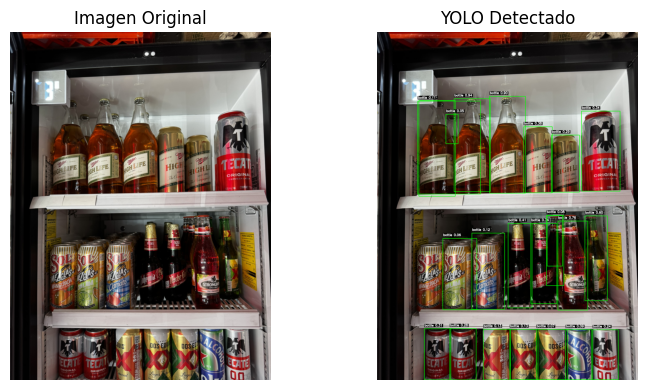

En total se tienen: 23 objetos


In [6]:
# Ruta del archivo en Google Drive
path_url = "/content/drive/My Drive/Colab Notebooks/Refris/B9D542B8-59F8-4CC0-B6F1-3C87D371A214_1_102_o.jpeg"

save_yolo = "/content/drive/My Drive/Colab Notebooks/Refris/YOLO/B9D542B8-59F8-4CC0-B6F1-3C87D371A214_1_102_o_YOLO.jpeg"

counts = get_yolo(path_url, save_yolo, visualizar=True)
print("En total se tienen: "+ str(counts) + " objetos")

Como se puede observar en la comparación, se lograrón identificar la mayoría de los objetos en el refrigerador. Es destacable comentar que incluso se logran identificar botellas por que no se encuentran en primer plano. La estimacion es mucho mejor que la realizada por el modelo SAM a pesar de que una de las latas en primer plano no se logró identificar.

Ahora vamos a realizar la identificación y conteo con el resto de imágenes que recabamos para este ejercicio. Para ello, se generó una función que lo realizará de 2 en 2 para que se pueda mostrar en el reporte en PDF.

In [7]:
def procesar_imagenes_por_pares(input_folder, output_folder, estado_path, sizeA=6, sizeB=3):
    # Crear carpeta de salida si no existe
    os.makedirs(output_folder, exist_ok=True)

    # Extensiones válidas de imagen
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

    # Leer último índice procesado (si existe)
    ultimo_index = 0
    if os.path.exists(estado_path):
        with open(estado_path, "r") as f:
            try:
                ultimo_index = int(f.read().strip())
            except:
                ultimo_index = 0

    # Obtener lista de archivos válidos y ordenados
    all_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)])
    total_files = len(all_files)

    # Si ya procesamos todos
    if ultimo_index >= total_files:
        print("✅ Todas las imágenes ya han sido procesadas.")
        return

    # Procesar un par de imágenes
    pares = all_files[ultimo_index:ultimo_index + 2]

    for filename in pares:
        input_path = os.path.join(input_folder, filename)
        name, ext = os.path.splitext(filename)
        output_filename = f"{name}_YOLO{ext}"
        output_path = os.path.join(output_folder, output_filename)

        try:
            count = get_yolo(input_path, output_path, visualizar=True, sizeA=sizeA, sizeB=sizeB)
            print(f"{filename}: {count} objetos detectados")
        except Exception as e:
            print(f"❌ Error al procesar {filename}: {e}")

    # Guardar el siguiente índice
    with open(estado_path, "w") as f:
        f.write(str(ultimo_index + len(pares)))


0: 640x480 36 bottles, 2 refrigerators, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


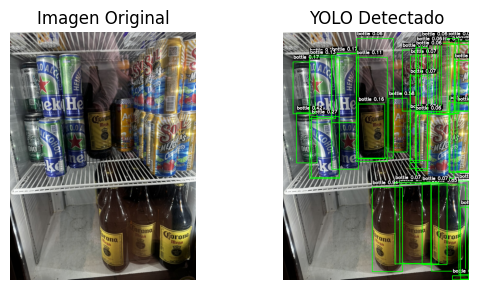

07592DFD-1B9C-468F-9C94-B7B380EE976C_1_105_c.jpeg: 36 objetos detectados

0: 640x480 35 bottles, 1 refrigerator, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


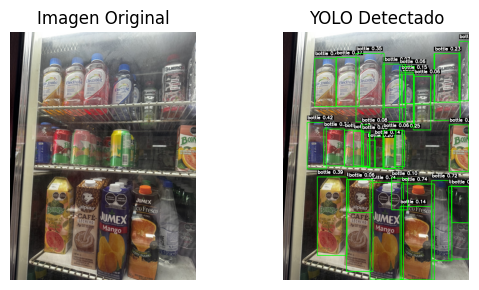

414DF0A6-4653-4799-AFC5-5A4B9E28F5CF_1_105_c.jpeg: 35 objetos detectados


In [8]:
input_folder="/content/drive/My Drive/Colab Notebooks/Refris/"
output_folder="/content/drive/My Drive/Colab Notebooks/Refris/YOLO/"
estado_path="/content/drive/My Drive/Colab Notebooks/Refris/estado_procesamiento.txt"
procesar_imagenes_por_pares(input_folder, output_folder, estado_path)


0: 640x480 34 bottles, 1 refrigerator, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


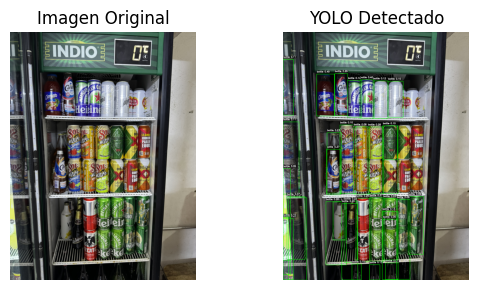

648A8D02-6456-4FCF-BDE6-79B59923A592_1_102_o.jpeg: 34 objetos detectados

0: 640x480 43 bottles, 2 refrigerators, 13.1ms
Speed: 4.4ms preprocess, 13.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


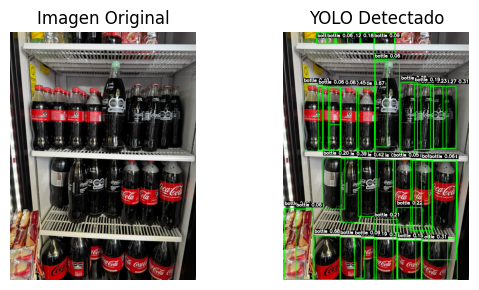

848346A9-24DA-4AF8-B91D-E6E3D6046BAF_1_105_c.jpeg: 43 objetos detectados


In [9]:
procesar_imagenes_por_pares(input_folder, output_folder, estado_path)


0: 640x480 34 bottles, 4 refrigerators, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


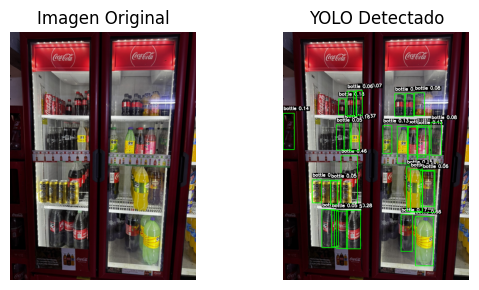

9DA9A02E-447A-4B2A-87FA-3B59395BE1E7_1_105_c.jpeg: 34 objetos detectados

0: 640x480 39 bottles, 4 refrigerators, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


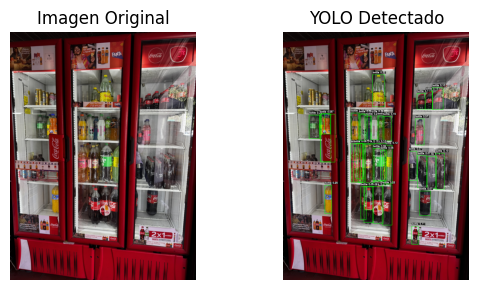

AD01DFA9-C0E6-47B6-9378-B58DB835F2C1_1_102_o.jpeg: 39 objetos detectados


In [10]:
procesar_imagenes_por_pares(input_folder, output_folder, estado_path)


0: 640x480 33 bottles, 1 bowl, 1 refrigerator, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


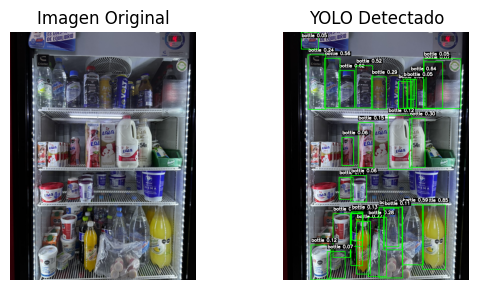

B1AE4A21-A7AA-42F9-84ED-5A292DDB1CB6_1_105_c.jpeg: 33 objetos detectados

0: 640x480 23 bottles, 1 refrigerator, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


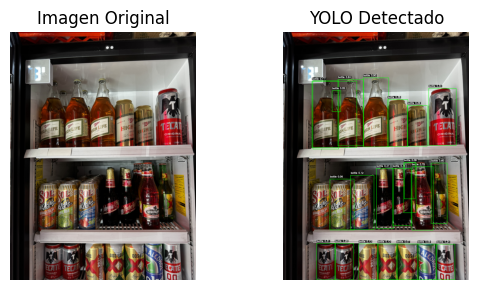

B9D542B8-59F8-4CC0-B6F1-3C87D371A214_1_102_o.jpeg: 23 objetos detectados


In [11]:
procesar_imagenes_por_pares(input_folder, output_folder, estado_path)


0: 640x480 25 bottles, 1 refrigerator, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


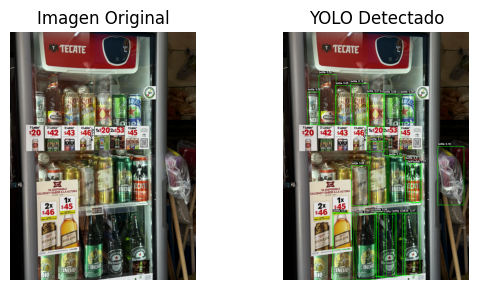

C11ABDCB-2BC1-42E2-8634-948CD458FB2B_1_102_o.jpeg: 25 objetos detectados

0: 640x480 1 umbrella, 43 bottles, 4 refrigerators, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


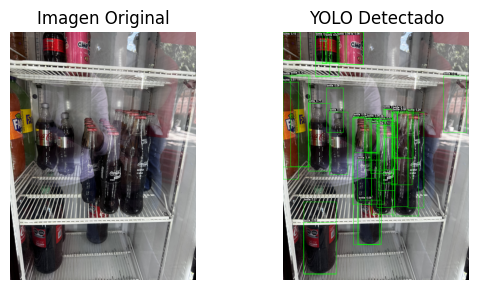

F41B4973-B4EC-457E-8DC0-B0AC7C0C2CA2_1_102_o.jpeg: 43 objetos detectados


In [12]:
procesar_imagenes_por_pares(input_folder, output_folder, estado_path)

In [13]:
procesar_imagenes_por_pares(input_folder, output_folder, estado_path)

✅ Todas las imágenes ya han sido procesadas.


# Conclusiones
A lo largo del proyecto, se pudo constatar que el modelo YOLO ofrece una mejora significativa en la identificación y el conteo de objetos en comparación con el modelo SAM. Una de las principales ventajas de YOLO es la posibilidad de seleccionar clases específicas de interés, lo cual no es posible con SAM, lo que brinda un mayor control y precisión en tareas específicas.

Otro aspecto que llamó la atención fue la diferencia en tiempos de procesamiento. Mientras que YOLO procesa una imagen en aproximadamente un segundo, SAM puede tardar hasta 30 segundos por imagen, lo que representa una ventaja considerable para tareas que requieren velocidad.

Este ejercicio también fue valioso para poner en práctica el uso de modelos preentrenados con imágenes reales, lo cual permitió identificar tanto fortalezas como limitaciones en cada enfoque. Queda abierta la puerta para explorar aplicaciones más complejas, como la detección en secuencias de video, y seguir el desarrollo de estas tecnologías, que continúan evolucionando rápidamente.